In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf
from statsmodels.graphics.tsaplots import plot_acf
from lmfit import Model
import plotly.express as px
cf.go_offline()

## Зависимость давления от плотности
Данные получены при T=2.0. Система приведена к температуре термостатом, затем термостат выключен, и сняты данные для давления в NVE конфигурации. Данные совпадают или близки с NVT конфигурацией, так как система находится в равновесии. Обрезки потенциала нет, единицы измерения относительные. N=512

Полученные данные совпадают или близки к приведенным в D. Frenkel, B. Smith. Understanding molecular simulation, стр. 53, левый график.
Даннные хорошо описываются зависимостью $$p=Ae^{B \rho}$$ где $A=(81 \pm 7) \times 10^{-3}$ и $B=5.21 \pm 0.10$

In [401]:
ro = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
p = []
for iro in ro:
    name = "p_rho/"+str(iro)+".csv"
    df = pd.read_csv(name)
    pressure = df['P'].loc[80000:100000].mean()
    std = df['P'].loc[80000:100000].std()
    p.append(pressure)
    print("ro="+f'{iro:.2f}'+" p="+f'{pressure:.2f}'+" std="+f'{std:.2f}')
#print(p)

ro=0.10 p=0.18 std=0.01
ro=0.20 p=0.32 std=0.04
ro=0.30 p=0.44 std=0.04
ro=0.40 p=0.68 std=0.10
ro=0.50 p=0.94 std=0.13
ro=0.60 p=1.95 std=0.15
ro=0.70 p=3.02 std=0.10
ro=0.80 p=5.32 std=0.16
ro=0.90 p=8.82 std=0.18


In [402]:
fig = px.scatter(x=ro,y=p,labels={'x':'density', 'y':'pressure'})
fig.update_layout(template='plotly_white')
fig.show()

In [403]:
def func(x, a, b):
    return a*np.e**(b*x)

In [404]:
mod = Model(func)
result = mod.fit(p, x=ro, a=1, b=1)
print(result.fit_report())
A = float(result.params['a'])
B = float(result.params['b'])

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 9
    # variables        = 2
    chi-square         = 0.06618177
    reduced chi-square = 0.00945454
    Akaike info crit   = -40.2131735
    Bayesian info crit = -39.8187243
[[Variables]]
    a:  0.08158247 +/- 0.00671523 (8.23%) (init = 1)
    b:  5.20519677 +/- 0.09678886 (1.86%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.994


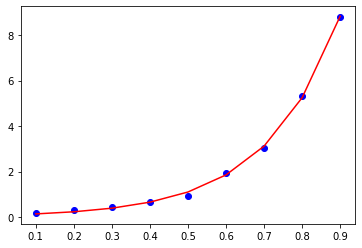

In [405]:
plt.plot(ro, p, 'bo', label='data')
plt.plot(ro, result.best_fit, 'r-', label='fit')
plt.show()

## Зависимость флуктуации давления от количества частиц

Давление - интенсивная термодинамическая величина. Пусть $P$ - суммарное давление системы, $p_{n}$ - давление подсистемы. Тогда, они связаны соотношением $P=\frac{1}{N} \sum_{n} p_{n}$. Тогда, флуктуация давление зависит от количества частиц, как $$ \sigma_P = \frac{\sigma_{p_{n}}}{\sqrt{N}} $$

Полученные данные для плотности $\rho = 0.6$ соответствуют этой зависимости. Лучший фит данный получается при добавлении константы к зависимости. Это можно связать с флуктуацией, вызванной неточностью вычислений, которая не является интенсивной величиной.

In [406]:
N = [200,250,300,400,500,600,700]
dp = []
for n in N:
    name = "dp_N/"+str(n)+".csv"
    df = pd.read_csv(name)
    pressure = df['P'].loc[50000:100000].mean()
    std = df['P'].loc[50000:100000].std()
    dp.append(std)
    print("N="+str(n)+" p="+f'{pressure:.2f}'+" std="+f'{std:.2f}')

N=200 p=1.98 std=0.27
N=250 p=1.79 std=0.23
N=300 p=1.64 std=0.19
N=400 p=1.86 std=0.17
N=500 p=1.80 std=0.15
N=600 p=1.98 std=0.13
N=700 p=1.70 std=0.12


In [407]:
fig = px.scatter(x=N,y=dp,labels={'x':'Number of particles', 'y':'Fluctuation of pressure'})
fig.update_layout(template='plotly_white')
fig.show()

In [408]:
def dfunc(x, a, c):
    return a/np.sqrt(x)+c

In [409]:
dmod = Model(dfunc)
dresult = dmod.fit(dp, x=N, a=3.4, c=0)
print(dresult.fit_report())

[[Model]]
    Model(dfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 7
    # variables        = 2
    chi-square         = 3.3877e-04
    reduced chi-square = 6.7754e-05
    Akaike info crit   = -65.5527263
    Bayesian info crit = -65.6609060
[[Variables]]
    a:  4.30187819 +/- 0.27546512 (6.40%) (init = 3.4)
    c: -0.04264219 +/- 0.01469791 (34.47%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, c) = -0.977


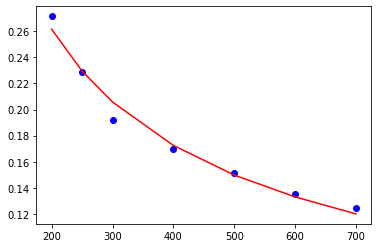

In [410]:
plt.plot(N, dp, 'bo', label='data')
plt.plot(N, dresult.best_fit, 'r-', label='fit')
plt.show()

## Сжимаемость
Согласно http://www.sklogwiki.org/SklogWiki/index.php/Compressibility, изотермическая сжимаемость вычисляется, как $$\kappa _{T} = \frac{1}{\rho} \frac{\partial \rho}{\partial p} $$

Эту зависимость можно аналитически получить из зависимости $p(\rho)$: $$ \kappa _{T} = \frac{1}{\rho} \frac{\partial \rho}{\partial p} = \frac{1}{\rho} \frac{\partial \frac{1}{B} ln(\frac{p}{A})}{\partial p} = \frac{1}{\rho} \frac{1}{B p} = \frac{1}{\rho} \frac{1}{B A e^{B\rho}} $$

In [411]:
def kapp(x):
    return 1/(x*A*B*np.e**(B*x))

In [412]:
t = np.arange(0.1, 1.0, 0.01)
fig = px.line(x=t,y=kapp(t),labels={'x':'density', 'y':'compressibility'})
fig.update_layout(template='plotly_white')
fig.show()